# 3장 KNN

In [1]:
#라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from sklearn.metrics import accuracy_score
from collections import Counter

## 3.1 시뮬레이션 예제

In [2]:
#데이터 생성

random.seed(4200)
blue_means = np.random.multivariate_normal([1,0],[[1,0],[0,1]],10)
orange_means = np.random.multivariate_normal([0,1],[[1,0],[0,1]],10)

num_samples = 5500
blue_samples = []
orange_samples = []

for i in range(num_samples):
    blue_mk = random.sample(list(blue_means),k=1)[0]
    blue_sample = np.random.multivariate_normal(blue_mk,[[0.1,0],[0,0.1]],1)
    blue_samples.append(np.squeeze(blue_sample))
    
    orange_mk = random.sample(list(orange_means),k=1)[0]
    orange_sample = np.random.multivariate_normal(orange_mk,[[0.1,0],[0,0.1]],1)
    orange_samples.append(np.squeeze(orange_sample))
    
num_train_samples = 500
train_samples = (blue_samples[:num_train_samples], orange_samples[:num_train_samples])
test_samples = (blue_samples[num_train_samples:], orange_samples[num_train_samples:])

X_train=[]
y_train=[]

for j in range(len(train_samples)):
    for data in train_samples[j]:
        y_train.append(j)
        temp = []
        temp += [data[0],data[1]]
        
        X_train.append(temp)
        
y_train = np.array(y_train)
X_train = np.array(X_train)

df_train = pd.DataFrame(X_train, columns=['x1','x2'])
df_train['y'] = y_train

X_test=[]
y_test=[]

for j in range(len(test_samples)):
    for data in test_samples[j]:
        y_test.append(j)
        temp = []
        temp += [data[0],data[1]]
        
        X_test.append(temp)
        
y_test = np.array(y_test)
X_test = np.array(X_test)

df_test = pd.DataFrame(X_test, columns=['x1','x2'])
df_test['y'] = y_test

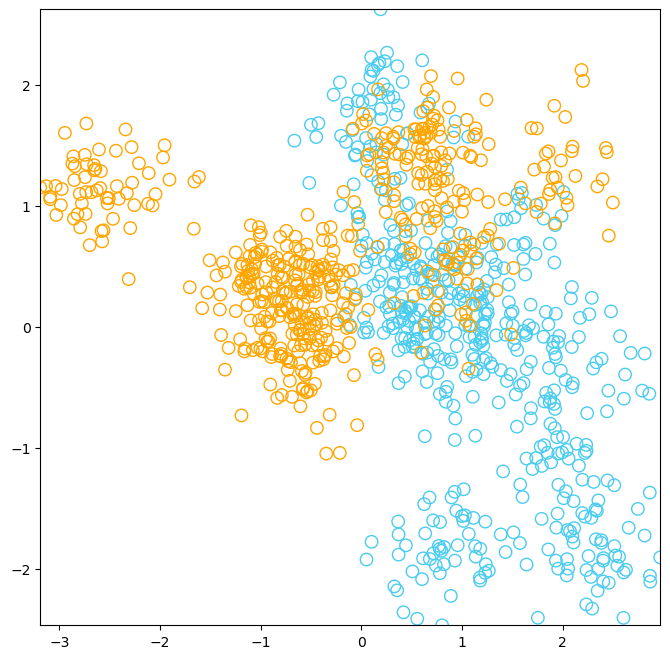

In [3]:
#데이터 분포

fig = plt.figure(figsize=(8,8))
colors = ['#4accf0','orange']

for j in range(len(train_samples)):
    x1_s = []
    x2_s = []
    
    for data in train_samples[j]:
        x1_s.append(data[0])
        x2_s.append(data[1])
        
    plt.scatter(x1_s,x2_s, s=80,facecolor='none', edgecolors=colors[j])
        
num_grid = 100
grid_x1 = np.linspace(min(df_train['x1']), max(df_train['x1']), num_grid+1)
grid_x2 = np.linspace(min(df_train['x2']), max(df_train['x2']), num_grid+1)
plt.xlim(min(df_train['x1']),max(df_train['x1']))
plt.ylim(min(df_train['x2']),max(df_train['x2']))

plt.show()

In [4]:
X_train = df_train.iloc[:,:-1].values
X_test = df_test.iloc[:,:-1].values
y_train = df_train.iloc[:,-1].values
y_test = df_test.iloc[:,-1].values

In [5]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [6]:
from sklearn.metrics import accuracy_score
y_pred = knn.predict(X_test)
print("정확도: {}".format(accuracy_score(y_test,y_pred)))

정확도: 0.8925


### 모델 구현

In [7]:
def knn_predict(data,X,y,k=50):
    distances = []
    for val in X:
        distance = np.linalg.norm(data-val)
        distances.append(distance)
        
    distances = np.array(distances)
    if k < len(distances):
        idx = np.argpartition(distances, k)
        prediction = Counter(y[idx[:k]]).most_common()[0][0]
    else:
        prediction = Counter(y).most_common()[0][0]
    return prediction

In [8]:
k = 50
predict = []
for j in range(len(df_test['x1'])):
    data = [df_test['x1'][j],df_test['x2'][j]]
    data = np.array(data)
    predict.append(knn_predict(data,X_test,y_test,k))

predict = np.array(predict)
accuracy = (y_test==predict).mean()
print(accuracy)

0.8972


### 시각화

In [9]:
#결정경계 시각화 함수
def get_boundary(data, mod, target):
    temp = []
    for i in range(len(data)):
        center = data[i]
        if (i+1)%mod >1:
            direction = [i-1,i+1,i+mod,i-mod]
        elif (i+1)%mod ==1:
            direction = [i+1,i+mod,i-mod]
        else:
            direction = [i-1,i+mod,i-mod]
            
        valid_idx = [x for x in direction if (x>=0 and x<= len(data)-1)]
        
        for v in valid_idx:
            if center != data[v]:
                temp.append(i)
                continue
                
    res = []
    for r in list(set(temp)):
        if data[r] == target:
            res.append(r)
            
    return list(set(res))

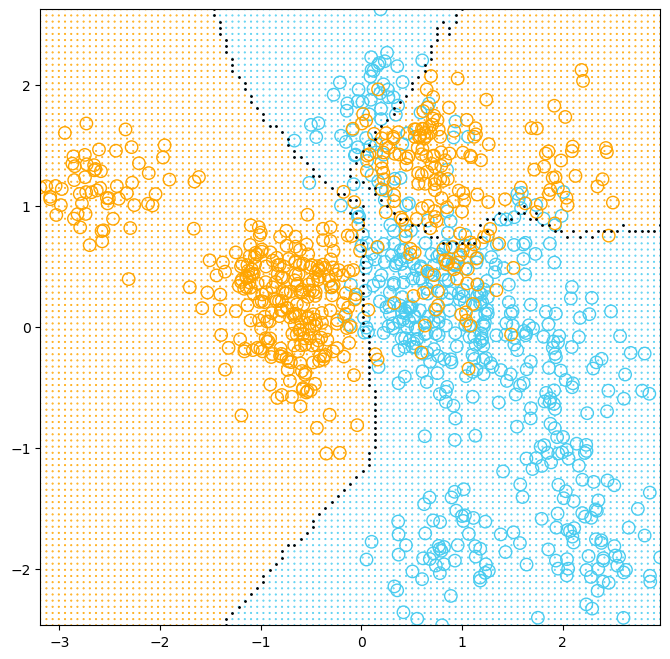

In [10]:
num_grid = 100
grid_x1 = np.linspace(min(df_train['x1']), max(df_train['x1']), num_grid+1)
grid_x2 = np.linspace(min(df_train['x2']), max(df_train['x2']), num_grid+1)

temp_x1, temp_x2 = np.meshgrid(grid_x1,grid_x2)
positions = np.vstack([temp_x2.ravel(), temp_x1.ravel()])

k = 50
grid_colors = []
data = []

for i in range(positions.shape[1]):
    pt = [positions[1][i],positions[0][i]]
    data.append(pt)
data = np.array(data)

y_pred = knn.predict(data)

for i in range(positions.shape[1]):
    grid_colors.append(colors[y_pred[i]])
    
boundary_idx = get_boundary(grid_colors,101,'#4accf0')
bx1 = positions[::-1][0][boundary_idx]
bx2 = positions[::-1][1][boundary_idx]

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')

plt.xlim(min(df_train['x1']), max(df_train['x1']))
plt.ylim(min(df_train['x2']), max(df_train['x2']))

for j in range(len(train_samples)):
    x1_s = []
    x2_s = []
    
    for data in train_samples[j]:
        x1_s.append(data[0])
        x2_s.append(data[1])
        
    plt.scatter(x1_s,x2_s, s=80,facecolor='none', edgecolors=colors[j])
    
plt.scatter(*positions[::-1],color=grid_colors,s=0.25,zorder=-10)
plt.scatter(bx1,bx2,s=1,color='k')
plt.show()

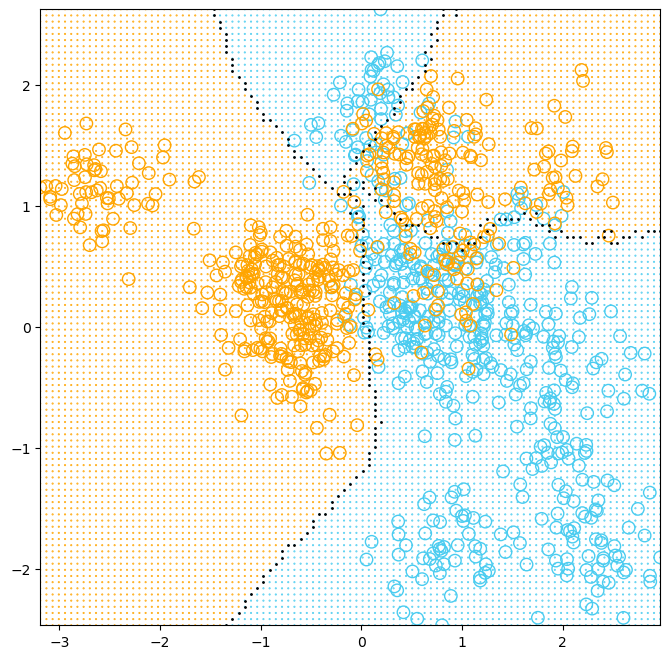

In [11]:
num_grid = 100
grid_x1 = np.linspace(min(df_train['x1']), max(df_train['x1']), num_grid+1)
grid_x2 = np.linspace(min(df_train['x2']), max(df_train['x2']), num_grid+1)

temp_x1, temp_x2 = np.meshgrid(grid_x1,grid_x2)
positions = np.vstack([temp_x2.ravel(), temp_x1.ravel()])

k = 50
grid_colors = []
for i in range(positions.shape[1]):
    data = np.array([positions[1][i],positions[0][i]])
    grid_colors.append(colors[knn_predict(data,X_train,y_train,k)])
    
boundary_idx = get_boundary(grid_colors,101,'#4accf0')
bx1 = positions[::-1][0][boundary_idx]
bx2 = positions[::-1][1][boundary_idx]

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')

plt.xlim(min(df_train['x1']), max(df_train['x1']))
plt.ylim(min(df_train['x2']), max(df_train['x2']))

for j in range(len(train_samples)):
    x1_s = []
    x2_s = []
    
    for data in train_samples[j]:
        x1_s.append(data[0])
        x2_s.append(data[1])
        
    plt.scatter(x1_s,x2_s, s=80,facecolor='none', edgecolors=colors[j])
    
plt.scatter(*positions[::-1],color=grid_colors,s=0.25,zorder=-10)
plt.scatter(bx1,bx2,s=1,color='k')
plt.show()

## 3.2 실제 데이터 예제

In [12]:
#데이터 불러오기
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']

dataset = pd.read_csv('./iris.data', names=names) 

In [13]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,4].values

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.20)

In [15]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.fit_transform(X_test)

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=50)

In [17]:
from sklearn.metrics import accuracy_score
y_pred = knn.predict(X_test)
print("정확도: {}".format(accuracy_score(y_test,y_pred)))

정확도: 0.9
